In [65]:
using FCSeqTools
using Statistics
using Random
using Distances
using Plots
using StatsBase
using Random

letter_matrix = do_letter_matrix("Twister_Ribozyme.fasta")
training_data = do_number_matrix_rna(letter_matrix, 1)

2720×67 Matrix{Int8}:
 5  4  1  1  1  1  1  2  4  2  2  3  2  …  3  1  3  3  1  3  3  3  4  4  3  3
 4  4  4  4  4  1  1  4  2  1  4  1  2     4  3  1  3  1  1  3  3  1  1  1  1
 4  2  4  4  4  1  1  2  4  2  2  3  2     3  1  3  3  1  3  3  3  4  4  3  3
 4  1  1  1  4  1  1  2  4  2  2  3  2     3  1  3  3  1  3  3  3  4  4  3  3
 2  4  2  1  4  1  1  2  4  2  2  3  2     3  1  3  3  1  3  3  3  4  4  3  3
 3  4  4  3  2  1  1  2  4  2  4  1  2  …  3  1  3  3  1  3  2  1  2  1  1  2
 4  4  3  4  1  1  1  2  4  2  2  3  2     3  1  3  3  1  3  3  4  4  4  3  3
 1  4  1  2  4  1  1  2  4  2  2  3  2     3  1  3  3  1  3  3  3  4  4  3  3
 3  4  2  4  1  1  1  2  4  2  2  3  2     3  1  3  3  1  3  3  3  3  3  3  2
 3  2  2  4  4  1  1  4  3  2  1  3  2     3  2  1  3  1  3  2  3  3  3  3  1
 4  2  3  3  4  1  1  4  3  2  3  3  2  …  3  2  1  3  1  3  2  2  1  2  3  1
 4  4  2  3  4  1  1  4  3  2  3  3  2     3  2  1  3  1  3  3  3  1  3  1  1
 3  2  1  3  4  1  1  2  4  2  2  3  2    

In [73]:
Random.seed!(1)

results = eaDCA(5, 0.1, 12000, training_data, "training_log.txt");

artificial_seq = results[3]
h_i = results[5]
J_ij = results[4];

Fully connected model has 2211 edges and a score around ~ 0.95

L = 67               Profile Model :    Score = -0.005    <E> = 74.33    log(Z) = 0.0   S = 74.33   e_t  = 1.47

[17  30]  iter: 1   edges: 1   complex: 0.05%
[16  31]  iter: 2   edges: 2   complex: 0.09%
[18  29]  iter: 3   edges: 3   complex: 0.14%
[40  62]  iter: 4   edges: 4   complex: 0.18%
[35  48]  iter: 5   edges: 5   complex: 0.23%
[11  55]  iter: 6   edges: 6   complex: 0.27%
[15  32]  iter: 7   edges: 7   complex: 0.32%
[14  33]  iter: 8   edges: 8   complex: 0.36%
[3  65]  iter: 9   edges: 9   complex: 0.41%
[19  28]  iter: 10   edges: 10   complex: 0.45%
[39  63]  iter: 11   edges: 11   complex: 0.5%
[36  47]  iter: 12   edges: 12   complex: 0.54%
[9  57]  iter: 13   edges: 13   complex: 0.59%
[2  66]  iter: 14   edges: 14   complex: 0.63%
[8  58]  iter: 15   edges: 15   complex: 0.68%   Score = 0.435    <E> = 60.43    log(Z) = 0.03   S = 60.46   e_t  = 21.18
[34  49]  iter: 16   edges: 16   complex: 0.72%
[10

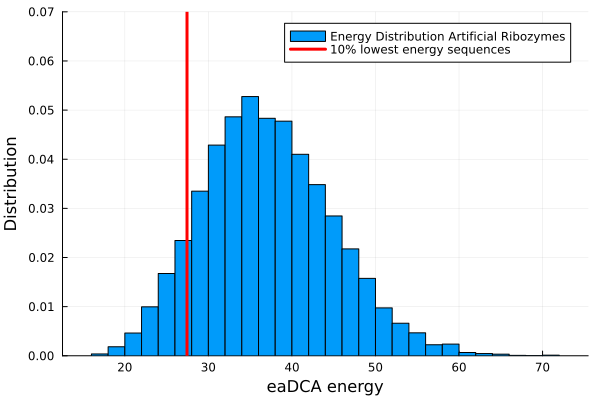

In [74]:
energy = sequences_energy(artificial_seq, 5, h_i, J_ij)
threshold = quantile(energy, 0.1)
mask = energy .<= threshold
low_energy_sequences = artificial_seq[mask,:]
print_fasta_to_file_rna(low_energy_sequences, "selected_sequences.fasta", "artificial_seq")

histogram(energy, normed=true, bins=30, label="Energy Distribution Artificial Ribozymes",
xlabel = "eaDCA energy", ylabel = "Distribution")
vline!([threshold], color=:red, label="10% lowest energy sequences", linewidth=3, ylims= (0,0.07))

In [75]:
function text_to_vector(filename)
    # Open the file in read mode
    open(filename, "r") do file
        content = read(file, String)
        words = split(content)
        numeric_values = parse.(Float64, words)

        return numeric_values
    end
end


text_to_vector (generic function with 1 method)

In [ ]:
wild_type = training_data[1,:]
bias_strength = 1.5
delta = freq_single_point(wild_type',5,0)
biased_sample = sample_from_model(Jij, hi + bias_strength*delta, 3000,50)

distances = []
for i in 1:length(biased_sample[:,1])
    push!(distances, hamming(wild_type, biased_sample[i,:]))
end

mask = distances.==5
mutants_5 = biased_sample[mask,:]


print_fasta_to_file_rna(mutants_5, "5_point_mutants.fasta", "mutant")
    

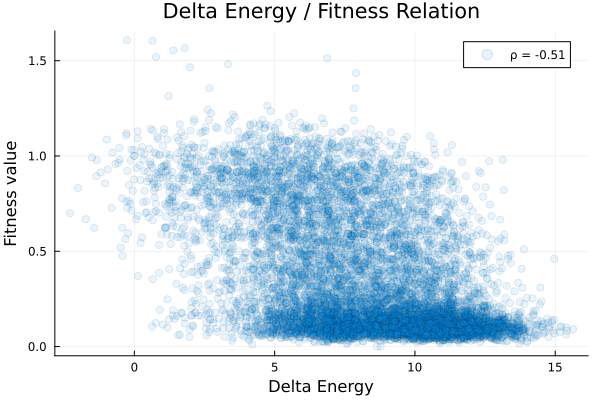

In [103]:
MS_letter = do_letter_matrix("Mutational_Scanning.fasta")
MS_matrix = do_number_matrix_rna(MS_letter, 1.0)

fitness = text_to_vector("MS.fitness")
energy = sequences_energy(MS_matrix, 5, h_i, J_ij)
wt_energy = energy[1]
delta_energy = energy .- wt_energy

ρ = round(digits=2,cor(delta_energy, fitness))
scatter(delta_energy, fitness, alpha = 0.1, xlabel = "Delta Energy", ylabel = "Fitness value", label = "ρ = $(ρ)", 
    title = "Delta Energy / Fitness Relation")
